# Extract phases - 4 site - L-BFGS-B - round 2
Created 10/11/2025

Objectives:
* Extract the fermionic and proj rep group cohomologies from the solutions calculated [here](save_solutions_4_site_lbfgsb_round_2.ipynb)

# Package imports

In [1]:
import sys

In [2]:
sys.path.append("../../../")

In [3]:
from itertools import chain, groupby, combinations
import re

from collections import Counter, namedtuple, defaultdict

In [4]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os
import pickle

In [5]:
import numpy as np
from jax import numpy as jnp
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import scipy

In [6]:
import quimb as qu
import quimb.tensor as qtn
from quimb.tensor.optimize import TNOptimizer

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:36: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:73: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


# Load data

## Wavefunctions

In [7]:
DATA_DIR_1 = r"../../../data/interpolated_trivial_to_nontrivial_fermionic_trivial_proj_rep_200_site_dmrg/"
DATA_DIR_2 = r"../../../data/interpolated_nontrivial_fermionic_proj_rep_to_nontrivial_proj_rep_200_site_dmrg/"

In [8]:
def parse_file_name(file_name):
    interpolation = int(file_name.split('_')[0])/100

    return interpolation

In [9]:
loaded_data_triv_proj_rep = dict()
energies_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_1))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_1, local_file_name, ignore_unknown=False)

    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_triv_proj_rep[data_info]=data['wavefunction']
        energies_triv_proj_rep[data_info]=data['energy']

In [10]:
loaded_data_non_triv_proj_rep = dict()
energies_non_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_2))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_2, local_file_name, ignore_unknown=False)

    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_non_triv_proj_rep[data_info]=data['wavefunction']
        energies_non_triv_proj_rep[data_info]=data['energy']

In [11]:
Counter(
    tuple(psi.get_B(i).get_leg_labels())
    for psi in loaded_data_triv_proj_rep.values()
    for i in range(psi.L)
)

Counter({('vL', 'p', 'vR'): 4200})

In [12]:
Counter(
    tuple(psi.get_B(i).get_leg_labels())
    for psi in loaded_data_non_triv_proj_rep.values()
    for i in range(psi.L)
)

Counter({('vL', 'p', 'vR'): 4200})

## Gate & circuit functions

In [13]:
def single_qubit_layer(circ, gate_round=None):
    """Apply a parametrizable layer of single qubit ``U3`` gates.
    """
    for i in range(circ.N):
        # initialize with random parameters
        params = qu.randn(3, dist='uniform')
        circ.apply_gate(
            'U3',
            *params,
            i,
            gate_round=gate_round,
            parametrize=True
        )

In [14]:
def two_qubit_layer(circ, gate2='CZ', start=0, gate_round=None):
    """Apply a layer of constant entangling gates.
    """
    num_sites = circ.N # Assuming this is even
    sites = [
        i % num_sites
        for i in range(start, start + num_sites)
    ]
    
    site_pairs = list(zip(sites[::2], sites[1::2]))

    for i, j in site_pairs:
        circ.apply_gate(
            gate2,
            i,
            j,
            gate_round=gate_round
        )

    if (num_sites % 2) == 1:
        circ.apply_gate(
            gate2,
            sites[0],
            sites[-1],
            gate_round=gate_round
        )

In [15]:
def ansatz_circuit(n, depth, first_site=0, gate2='CZ', gate_tag=None,
                   **kwargs):
    """Construct a circuit of single qubit and entangling layers.
    """
    circ = qtn.Circuit(n, **kwargs)

    for r in range(depth):
        # single qubit gate layer
        single_qubit_layer(circ, gate_round=r)

        # alternate between forward and backward CZ layers
        two_qubit_layer(
            circ, gate2=gate2, gate_round=r, start=r % 2)

    # add a final single qubit layer
    single_qubit_layer(circ, gate_round=r + 1)

    circ = circ.uni

    no_labels_index_map = dict()

    old_site = 0
    new_site = first_site

    while old_site < n:
        if (new_site % 2) == 0:
            no_labels_index_map[f'{old_site}'] = f'{new_site}-0'
            no_labels_index_map[f'{old_site+1}'] = f'{new_site}-1'
            old_site += 2
        else:
            no_labels_index_map[f'{old_site}'] = f'{new_site}'
            old_site += 1
        new_site += 1

    assert old_site == n
    
    if gate_tag is not None:
        for t in circ.tensors:
            t.add_tag(gate_tag)

    index_labels = ['k', 'b']

    # Include labels in map
    index_map = {
        f'{l}{k}': f'{l}{v}'
        for k, v in no_labels_index_map.items()
        for l in index_labels
    }

    circ.reindex(index_map, inplace=True)

    return circ

In [16]:
def ansatz_circuit_pair(leftmost_symmetry_site,
    num_symmetry_sites, num_boundary_sites, depth,
    gate2='CZ', **kwargs):
    """Construct a circuit of single qubit and entangling layers.
    """
    left_start_site = leftmost_symmetry_site-num_boundary_sites
    right_start_site = leftmost_symmetry_site+num_symmetry_sites

    left_num_expanded_boundary_sites = sum(
        2 if (i % 2 == 0) else 1
        for i in range(left_start_site, left_start_site + num_boundary_sites)
    )

    left_circuit = ansatz_circuit(
        left_num_expanded_boundary_sites,
        depth,
        first_site=left_start_site,
        gate2=gate2,
        gate_tag='left',
        **kwargs
    )

    right_num_expanded_boundary_sites = sum(
        2 if (i % 2 == 0) else 1
        for i in range(right_start_site, right_start_site + num_boundary_sites)
    )

    right_circuit = ansatz_circuit(
        right_num_expanded_boundary_sites,
        depth,
        first_site=right_start_site,
        gate2=gate2,
        gate_tag='right',
        **kwargs
    )

    circ_pair = (left_circuit & right_circuit)

    return circ_pair

In [17]:
def split_circ_pair(circ_pair):
    left_circuit = qtn.TensorNetwork(
        list(map(circ_pair.tensor_map.__getitem__, circ_pair.tag_map['left']))
    )

    right_circuit = qtn.TensorNetwork(
        list(map(circ_pair.tensor_map.__getitem__, circ_pair.tag_map['right']))
    )

    return (left_circuit, right_circuit)

## Boundary operator solutions

In [20]:
SOL_DIR = r"solutions_4_site_lbfgsb_round_2/"

In [21]:
file_name_pattern = re.compile(r'^(?:non_)?triv_\d\.\d+_\d_\d_\d+\.pickle$')

In [22]:
def parse_file_name(file_name):
    if not bool(file_name_pattern.match(file_name)):
        print(file_name)
        return None

    file_name = '.'.join((file_name.split('.'))[:-1])

    if file_name[0] == 'n':
        proj_rep=1
        b, bs, fs, i = file_name.split('_')[2:]
    elif file_name[0] == 't':
        proj_rep=0
        b, bs, fs, i = file_name.split('_')[1:]
    else:
        return None

    b = float(b)
    bs = int(bs)
    fs = int(fs)
    i = int(i)
    
    return (proj_rep, b, bs, fs, i)

In [23]:
def generate_circuit_from_params(params, leftmost_symmetry_site,
    num_symmetry_sites, num_boundary_sites, depth):
    circ_pair = ansatz_circuit_pair(
        leftmost_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        depth
    )

    left_circuit, right_circuit = split_circ_pair(circ_pair)
    left_params, right_params = params

    left_circuit.set_params(left_params)
    right_circuit.set_params(right_params)

    return (left_circuit, right_circuit)

In [24]:
num_boundary_sites=4
depth=5
left_most_symmetry_site=60
num_symmetry_sites=80
bond_dimension=6

total_physical_dim = 2**6

In [25]:
boundary_operator_solutions = dict()
boundary_operator_scores = dict()

for local_file_name in list(os.walk(SOL_DIR))[0][2]:
    f_name = r"{}/{}".format(SOL_DIR, local_file_name, ignore_unknown=False)

    key = parse_file_name(local_file_name)

    if key is not None:
        with open(f_name, 'rb') as f:
            final_score, params = pickle.load(f)

            circ_pair = generate_circuit_from_params(
                params,
                left_most_symmetry_site,
                num_symmetry_sites,
                num_boundary_sites,
                depth
            )
            
            boundary_operator_scores[key] = final_score
            boundary_operator_solutions[key] = circ_pair

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In future the tensor network returned by ``circ.uni`` will not be transposed as it is currently, to match the expectation from ``U = circ.uni.to_dense()`` behaving like ``U @ psi``. You can retain this behaviour with ``circ.get_uni(transposed=True)``.
  warnings.warn(


In [28]:
(
    len(boundary_operator_solutions),
    len(boundary_operator_scores)
)

(7560, 7560)

In [30]:
21*2*6*30

7560

### Check values

In [31]:
scores = list(boundary_operator_scores.values())

In [32]:
pd.Series(scores).describe()

count    7.560000e+03
mean     2.815634e-01
std      3.463702e-01
min     -4.768372e-07
25%      4.115686e-03
50%      5.982524e-02
75%      6.101296e-01
max      1.000000e+00
dtype: float64

In [33]:
next(iter(boundary_operator_solutions.keys()))

(0, 0.25, 1, 1, 7)

In [34]:
score_pairs = defaultdict(list)

for k, v in boundary_operator_scores.items():
    score_pairs[k[:-1]].append((k[-1], v))

In [35]:
best_score_pairs = {
    k: min(v, key=lambda x: x[1]) for k, v in score_pairs.items()
}

In [36]:
best_scores = [v[1] for v in best_score_pairs.values()]

In [37]:
len(best_score_pairs)

252

In [38]:
pd.Series(best_scores).describe()

count    2.520000e+02
mean     1.545960e-01
std      2.381216e-01
min     -4.768372e-07
25%      1.305535e-03
50%      2.369633e-02
75%      2.451194e-01
max      1.000000e+00
dtype: float64

In [39]:
best_boundary_operators = {
    k: boundary_operator_solutions[(*k, v[0])]
    for k, v in best_score_pairs.items()
    #if k[1] != 0.5
}

In [40]:
len(best_boundary_operators)

252

# Definitions

In [41]:
np_00 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

np_01 = np.array([
    [0, 1, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])

np_10 = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

np_11 = np.array([
    [0, 0, 0, 1],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [1, 0, 0, 0]
])

In [42]:
bosonic_np_symmetries = [
    np_00,
    np_01,
    np_10,
    np_11
]

In [43]:
np_I = np.array([
    [1, 0],
    [0, 1]
])

np_JW = np.array([
    [1, 0],
    [0, -1]
])

In [44]:
fermionic_np_symmetries = [np_I, np_JW]

In [45]:
symmetry_actions = [
    [[b, f] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [46]:
shifted_symmetry_actions = [
    [[f, b] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [47]:
def generate_problem_rdm(quimb_psi, symmetry_site_pairs, leftmost_symmetry_site,
                         num_symmetry_sites, num_boundary_sites):
    q_top = quimb_psi.copy(deep=True)
    for i, s in symmetry_site_pairs:
        q_top.gate(
            s,
            where=i,
            contract=False,
            inplace=True
        )
    
    indices_to_map = list(chain(
        range(leftmost_symmetry_site-num_boundary_sites, leftmost_symmetry_site),
        range(leftmost_symmetry_site+num_symmetry_sites, leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites)
    ))

    index_mapping = {f'k{i}': f'b{i}' for i in indices_to_map}

    q_bottom = (
        quimb_psi
        .copy()
        .reindex(index_mapping, inplace=True)
        .conj()
    )

    sites_to_contract = {
        'left': list(range(leftmost_symmetry_site-num_boundary_sites)),
        'middle': list(range(leftmost_symmetry_site, leftmost_symmetry_site+num_symmetry_sites)),
        'right': list(range(leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites, quimb_psi.L))
    }

    tags_to_contract = {
        k: [f'I{i}' for i in v]
        for k, v in sites_to_contract.items()
    }

    tn = (q_top & q_bottom)

    tnc = (
        tn
        .contract(tags_to_contract['left'])
        .contract(tags_to_contract['middle'])
        .contract(tags_to_contract['right'])
    )

    # Expand the d=4 qudit sites into 2 qubits.
    even_left_sites = [
        i for i in range(leftmost_symmetry_site - num_boundary_sites, leftmost_symmetry_site)
        if (i % 2 == 0)
    ]

    even_right_sites = [
        i for i in range(
            leftmost_symmetry_site + num_symmetry_sites,
            leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites
        )
        if (i % 2 == 0)
    ]

    for s in ['k', 'b']:
        left_sites = [even_left_sites[0], even_right_sites[0]]
        for i in left_sites:

            t = tnc.tensor_map[list(tnc.ind_map[f'{s}{i}'])[0]]
            tr = tnc.tensor_map[list(tnc.ind_map[f'{s}{i+1}'])[0]]
            vr = [
                ind for ind in t.inds if ind in tr.inds
            ][0]
            vl = [
                ind for ind in t.inds
                if ind not in [vr, f'{s}{i}']
            ]
        
            t.unfuse(
                {f'{s}{i}': [f'{s}{i}-0', f'{s}{i}-1']},
                {f'{s}{i}': [2, 2]},
                inplace=True
            )

            #t.split([f'{s}{i}-0', vl])

        right_sites = [even_left_sites[-1], even_right_sites[-1]]
        right_sites = [s for s in right_sites if s not in left_sites]
        for i in right_sites:

            t = tnc.tensor_map[list(tnc.ind_map[f'{s}{i}'])[0]]
            tl = tnc.tensor_map[list(tnc.ind_map[f'{s}{i-1}'])[0]]
            vl = [
                ind for ind in t.inds if ind in tl.inds
            ][0]
        
            t.unfuse(
                {f'{s}{i}': [f'{s}{i}-0', f'{s}{i}-1']},
                {f'{s}{i}': [2, 2]},
                inplace=True
            )

            #t.split([f'{s}{i}-0', vl])

        inner_sites = [
            s for s in even_left_sites + even_right_sites
            if s not in left_sites + right_sites
        ]

        """
        inner_sites = [
            *even_left_sites[1:-1],
            *even_right_sites[1:-1]
        ]
        """

        for i in inner_sites:

            t = tnc.tensor_map[list(tnc.ind_map[f'{s}{i}'])[0]]
            tl = tnc.tensor_map[list(tnc.ind_map[f'{s}{i-1}'])[0]]
            vl = [
                ind for ind in t.inds
                if ind not in [vr, f'{s}{i}']
            ]
        
            t.unfuse(
                {f'{s}{i}': [f'{s}{i}-0', f'{s}{i}-1']},
                {f'{s}{i}': [2, 2]},
                inplace=True
            )

            #t.split([f'{s}{i}-0', vl])
        
    return tnc

In [48]:
def generate_rdm_from_tenpy_psi(mps_psi, symmetry_site_pairs,
    leftmost_symmetry_site, num_symmetry_sites, num_boundary_sites):
    
    psi_arrays = list()
    psi_arrays.append(mps_psi.get_B(0, 'Th')[0, ...].to_ndarray())
    for i in range(1, mps_psi.L-1):
        psi_arrays.append(mps_psi.get_B(i).to_ndarray())
    psi_arrays.append(mps_psi.get_B(mps_psi.L-1)[..., 0].to_ndarray())
    
    q1 = (
        qtn
        .tensor_1d
        .MatrixProductState(psi_arrays, shape='lpr')
    )
    
    problem_rdm = generate_problem_rdm(
        q1,
        symmetry_site_pairs,
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites
    )

    return problem_rdm

## Optimisation functions

In [49]:
def loss(circ_pair, problem_rdm):
    c = (problem_rdm & circ_pair)^...

    c_abs_squared = (
        c
        *jnp.conjugate(c)
    )
    c_abs_squared = jnp.real(c_abs_squared)

    out = 1-c_abs_squared

    return out

## Extract SPT phase functions

In [50]:
def relabel_index(index, old_label, new_label):
    index_tail = index[len(old_label):]
    return new_label + index_tail

In [51]:
def relabel_circuit(circuit_tn, new_k_label, new_b_label, old_k_label='k',
                   old_b_label='b'):
    k_regex = re.compile(rf"^{old_k_label}\d+-?\d+$")
    b_regex = re.compile(rf"^{old_b_label}\d+-?\d+$")

    old_k_indices = [
        k for k in circuit_tn.ind_map
        if bool(re.search(k_regex, k))
    ]
    
    old_b_indices = [
        k for k in circuit_tn.ind_map
        if bool(re.search(b_regex, k))
    ]
    
    k_out_indices = [
        relabel_index(i, old_k_label, new_k_label)
        for i in old_k_indices
    ]
        
    b_out_indices = [
        relabel_index(i, old_b_label, new_b_label)
        for i in old_b_indices
    ]

    mapping = dict(
        chain(
            zip(old_k_indices, k_out_indices),
            zip(old_b_indices, b_out_indices)
        )
    )

    circuit_tn.reindex(mapping, inplace=True)

In [52]:
def get_right_fp_overlap(rdm, u_l, u_r, leftmost_symmetry_site,
                     num_symmetry_sites, num_boundary_sites):

    tn = rdm.copy(deep=True)

    fermionic_site_indices = [
        i
        for i in range(
            leftmost_symmetry_site+num_symmetry_sites,
            leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites
        )
        if i % 2 == 1
    ]

    top_fermionic_tensors = [
        (f'k{i}', next(map(tn.tensor_map.__getitem__, tn.ind_map[f'k{i}'])))
        for i in fermionic_site_indices
    ]

    bottom_fermionic_tensors = [
        (f'b{i}', next(map(tn.tensor_map.__getitem__, tn.ind_map[f'b{i}'])))
        for i in fermionic_site_indices
    ]

    for ind, t in top_fermionic_tensors:
        t.gate(
            np_JW,
            ind=ind,
            inplace=True
        )

    for ind, t in bottom_fermionic_tensors:
        t.gate(
            np_JW,
            ind=ind,
            transposed=True,
            inplace=True
        )

    out = (tn & u_l & u_r) ^ ...

    return out

In [53]:
def get_left_fp_overlap(rdm, u_l, u_r, leftmost_symmetry_site,
                     num_symmetry_sites, num_boundary_sites):

    tn = rdm.copy(deep=True)

    fermionic_site_indices = [
        i
        for i in range(
            leftmost_symmetry_site-num_boundary_sites,
            leftmost_symmetry_site
        )
        if i % 2 == 1
    ]

    top_fermionic_tensors = [
        (f'k{i}', next(map(tn.tensor_map.__getitem__, tn.ind_map[f'k{i}'])))
        for i in fermionic_site_indices
    ]

    bottom_fermionic_tensors = [
        (f'b{i}', next(map(tn.tensor_map.__getitem__, tn.ind_map[f'b{i}'])))
        for i in fermionic_site_indices
    ]

    for ind, t in top_fermionic_tensors:
        t.gate(
            np_JW,
            ind=ind,
            inplace=True
        )

    for ind, t in bottom_fermionic_tensors:
        t.gate(
            np_JW,
            ind=ind,
            transposed=True,
            inplace=True
        )

    out = (tn & u_l & u_r) ^ ...

    return out

In [54]:
def get_fp_charges(rdm, u_l, u_r, left_most_symmetry_site, num_symmetry_sites,
               num_boundary_sites):
    base_overlap = (rdm & u_l & u_r) ^ ...

    right_fp_overlap = get_right_fp_overlap(
        rdm,
        u_l,
        u_r,
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites
    )

    left_fp_overlap = get_left_fp_overlap(
        rdm,
        u_l,
        u_r,
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites
    )

    right_fp_charge = right_fp_overlap/base_overlap
    left_fp_charge = left_fp_overlap/base_overlap

    return (left_fp_charge, right_fp_charge, base_overlap)

# Extract SPT phase
## Fermionic group cohomology

In [55]:
num_boundary_sites=4
left_most_symmetry_site=60
num_symmetry_sites=80
bond_dimension=6

total_physical_dim = 2**6

In [56]:
fp_charges = dict()

for k, ops in best_boundary_operators.items():
    u_l, u_r = ops

    if k[0] == 0:
        tenpy_psi = loaded_data_triv_proj_rep[k[1]]
    elif k[0] == 1:
        tenpy_psi = loaded_data_non_triv_proj_rep[k[1]]

    bs = bosonic_np_symmetries[k[2]]
    fs = fermionic_np_symmetries[k[3]]

    symmetry_site_pairs = (
        [(i, bs) for i in range(left_most_symmetry_site, left_most_symmetry_site+num_symmetry_sites, 2)]
        + [(i, fs) for i in range(left_most_symmetry_site+1, left_most_symmetry_site+num_symmetry_sites+1, 2)]
    )

    rdm = generate_rdm_from_tenpy_psi(
        tenpy_psi,
        symmetry_site_pairs,
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites
    )

    out = get_fp_charges(
        rdm,
        u_l,
        u_r,
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites
    )

    fp_charges[k] = out

In [57]:
interpolation_values = np.round(np.linspace(0,1,21), 2)

In [58]:
fp_charges_array = np.zeros((2, len(interpolation_values), 3, 2, 2), dtype='complex')

for t_nt in range(2):
    for i, t in enumerate(interpolation_values):
        for b in range(1, 4):
            for jw in range(2):
                for side in range(2):
                    charge = fp_charges[(t_nt, t, b, jw)][side]
                    fp_charges_array[t_nt, i, b-1, jw, side] = charge

In [59]:
fp_charges_array.shape

(2, 21, 3, 2, 2)

In [60]:
fp_charges_array[:, 10, ...]

array([[[[ 1.20611516-1.63636127e-01j,  1.20611516-1.63636127e-01j],
         [ 1.07121558+1.22391505e-01j,  1.07121558+1.22391505e-01j]],

        [[ 1.        -4.86836111e-17j,  1.        +0.00000000e+00j],
         [ 1.        +1.09651320e-16j,  1.        +2.19302639e-16j]],

        [[ 0.98732736+5.56023421e-03j,  0.98732736+5.56023421e-03j],
         [ 0.06423922-1.31637488e-01j,  0.06423922-1.31637488e-01j]]],


       [[[ 1.02159792+1.00612874e-02j,  1.02159792+1.00612874e-02j],
         [ 0.97279486+9.33789428e-03j,  0.97279486+9.33789428e-03j]],

        [[-0.91320399+5.34203363e-02j, -0.91320399+5.34203363e-02j],
         [-0.99471125-1.64683252e-02j, -0.99471125-1.64683252e-02j]],

        [[-1.        -2.02480352e-16j, -1.        -1.01240176e-16j],
         [-1.        +4.24298087e-16j, -1.        -6.06140124e-17j]]]])

Clean up data.

In [61]:
np.max(np.abs(np.imag(fp_charges_array)))

0.16363612672684907

In [62]:
np.max(np.abs(np.imag(fp_charges_array[:, 10, ...])))

0.16363612672684907

In [63]:
np.max(np.abs(np.imag(fp_charges_array[:, :10, ...])))

5.356647035968515e-15

In [64]:
np.max(np.abs(np.imag(fp_charges_array[:, 11:, ...])))

1.428783926767147e-15

So ignore imaginary part and throw away critical points.

In [65]:
fp_charges_array = np.real(fp_charges_array)
fp_charges_array = np.delete(fp_charges_array, 10, axis=1)

In [66]:
np.all(np.abs(np.real(fp_charges_array)) == 1)

False

In [67]:
np.max(np.abs(np.abs(np.real(fp_charges_array)) - 1))

2.9976021664879227e-15

Ok, so all close to $\pm 1$.

In [68]:
np.max(np.abs(np.abs(fp_charges_array) - 1))

2.9976021664879227e-15

In [69]:
np.unique(fp_charges_array)

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [70]:
np.all(np.abs(fp_charges_array) == 1)

False

In [71]:
fp_charges_array = np.round(fp_charges_array, 0).astype('int')

In [72]:
np.unique(fp_charges_array)

array([-1,  1])

In [73]:
np.all(fp_charges_array[...,0] == fp_charges_array[...,1])

True

In [74]:
fp_charges_array = fp_charges_array[...,0]

In [75]:
np.all(fp_charges_array[...,0] == fp_charges_array[...,1])

True

In [76]:
fp_charges_array = fp_charges_array[...,0]

In [77]:
fp_charges_array.shape

(2, 20, 3)

In [78]:
fp_charges_array[0]

array([[-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1],
       [ 1,  1,  1]])

In [79]:
fp_charges_array[1, :]

array([[ 1, -1, -1],
       [ 1, -1, -1],
       [ 1, -1, -1],
       [ 1, -1, -1],
       [ 1, -1, -1],
       [ 1, -1, -1],
       [ 1, -1, -1],
       [ 1, -1, -1],
       [ 1, -1, -1],
       [ 1, -1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1],
       [-1,  1, -1]])

All agree with previous results! Consistent.

In [80]:
interpolation_values.shape

(21,)

In [81]:
sub_interpolation_values = np.delete(interpolation_values, 10)

In [82]:
sub_interpolation_values.shape

(20,)

In [83]:
fp_charges_array

array([[[-1,  1, -1],
        [-1,  1, -1],
        [-1,  1, -1],
        [-1,  1, -1],
        [-1,  1, -1],
        [-1,  1, -1],
        [-1,  1, -1],
        [-1,  1, -1],
        [-1,  1, -1],
        [-1,  1, -1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1]],

       [[ 1, -1, -1],
        [ 1, -1, -1],
        [ 1, -1, -1],
        [ 1, -1, -1],
        [ 1, -1, -1],
        [ 1, -1, -1],
        [ 1, -1, -1],
        [ 1, -1, -1],
        [ 1, -1, -1],
        [ 1, -1, -1],
        [-1,  1, -1],
        [-1,  1, -1],
        [-1,  1, -1],
        [-1,  1, -1],
        [-1,  1, -1],
        [-1,  1, -1],
        [-1,  1, -1],
        [-1,  1, -1],
        [-1,  1, -1],
        [-1,  1, -1]]])

In [84]:
colors = [
    'tab:blue',
    'tab:orange',
    'tab:green'
]   

In [85]:
symmetry_labels = [
    'II',
    'IX',
    'XI',
    'XX'
]

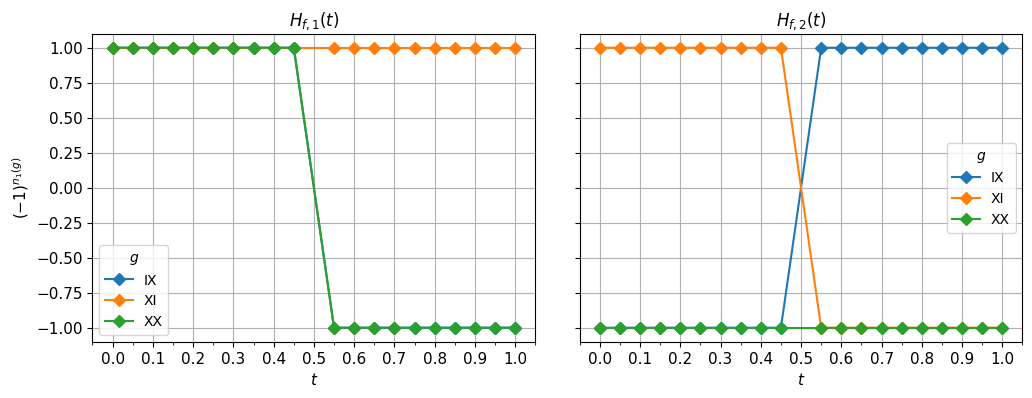

In [86]:
fig, (ax1, ax2) = plt.subplots(figsize=(12,4), ncols=2)

for j, (col, label) in enumerate(zip(colors, symmetry_labels[1:])):
    ax1.plot(
        sub_interpolation_values[::-1],
        fp_charges_array[0, :, j],
        color=col,
        label = label,
        marker='D'
    )

    ax2.plot(
        sub_interpolation_values[::-1],
        fp_charges_array[1, :, j],
        color=col,
        label = label,
        marker='D'
    )

for k, ax in enumerate([ax1, ax2]):
    ax.xaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(0.1)
    )
    ax.xaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.05)
    )
    
    
    ax.tick_params(
        axis='both',
        which='major',
        labelsize=11
    )
    
    ax.grid()
    ax.grid(
        which='minor',
        axis='y',
        linestyle='--',
        zorder=-1e10
    )
    ax.set_axisbelow(True)

    ax.set_ylabel(r'$(-1)^{n_1(g)}$', fontsize=11)
    ax.set_xlabel('$t$', fontsize=11)

    ax.title.set_text(rf'$H_{{f,{k+1}}}(t)$')
    ax.title.set_fontsize(12)

ax1.legend(loc='lower left', title='$g$')
ax2.legend(loc='center right', title='$g$')

ax2.set_ylabel('')
ax2.set_yticklabels([])

fig.subplots_adjust(wspace=0.1)

#fig.savefig(r'plots/n1_phase_fermionic_variational_unitary_2_site.png', dpi=200)

In [87]:
scores_array = np.zeros((2, len(interpolation_values), 3, 2), dtype='complex')

for t_nt in range(2):
    for i, t in enumerate(interpolation_values):
        for b in range(1, 4):
            for jw in range(2):
                score = fp_charges[(t_nt, t, b, jw)][2]
                scores_array[t_nt, i, b-1, jw] = score

In [88]:
pd.Series(np.abs(scores_array.flatten())).describe()

count    2.520000e+02
mean     8.986423e-01
std      1.949254e-01
min      7.281314e-08
25%      8.688381e-01
50%      9.880791e-01
75%      9.993472e-01
max      9.999997e-01
dtype: float64

In [89]:
scores_array.shape

(2, 21, 3, 2)

In [90]:
np.max(scores_array)

(0.9936181168638932-0.11278444912250009j)

In [91]:
np.max(
    np.delete(
        np.abs(
            np.abs(scores_array[...,0])
            - np.abs(scores_array[...,1])
        )
        ,
        10,
        axis=1
    )
)

0.24670426525688494

In [92]:
single_fp_charges = {k: np.real(np.round(v[0], 2)) for k, v in fp_charges.items()}

In [93]:
g = groupby(single_fp_charges.items(), key=lambda x: x[0][:-1])
single_fp_charges_deduplicated = dict()

for k, v in g:
    if k[1] != 0.5:
        values = [v1[1] for v1 in v]
        assert len(Counter(values)) == 1
        single_fp_charges_deduplicated[k] = values[0]

In [94]:
single_fp_charges_deduplicated

{(0, 0.25, 1): -1.0,
 (1, 0.25, 1): 1.0,
 (0, 0.35, 2): 1.0,
 (1, 0.6, 3): -1.0,
 (0, 0.75, 3): 1.0,
 (1, 0.9, 2): 1.0,
 (1, 0.55, 3): -1.0,
 (1, 0.55, 1): -1.0,
 (0, 0.45, 2): 1.0,
 (1, 0.6, 1): -1.0,
 (1, 0.25, 3): -1.0,
 (1, 0.0, 2): -1.0,
 (0, 0.9, 1): 1.0,
 (0, 0.65, 3): 1.0,
 (1, 0.05, 2): -1.0,
 (0, 0.15, 3): -1.0,
 (0, 0.0, 1): -1.0,
 (1, 0.75, 2): 1.0,
 (1, 0.85, 3): -1.0,
 (1, 1.0, 3): -1.0,
 (1, 0.3, 3): -1.0,
 (0, 0.9, 3): 1.0,
 (0, 0.85, 2): 1.0,
 (0, 0.2, 2): 1.0,
 (0, 0.4, 3): -1.0,
 (0, 0.05, 3): -1.0,
 (1, 0.95, 3): -1.0,
 (1, 0.7, 1): -1.0,
 (1, 0.1, 2): -1.0,
 (1, 0.2, 1): 1.0,
 (0, 0.25, 2): 1.0,
 (1, 0.35, 1): 1.0,
 (0, 0.05, 2): 1.0,
 (1, 0.35, 2): -1.0,
 (0, 0.1, 3): -1.0,
 (1, 0.7, 2): 1.0,
 (0, 0.55, 2): 1.0,
 (1, 0.45, 1): 1.0,
 (0, 0.7, 2): 1.0,
 (0, 0.8, 3): 1.0,
 (1, 0.2, 3): -1.0,
 (1, 0.1, 3): -1.0,
 (1, 0.65, 3): -1.0,
 (0, 0.2, 1): -1.0,
 (1, 0.15, 1): 1.0,
 (1, 0.15, 3): -1.0,
 (1, 0.8, 3): -1.0,
 (1, 0.65, 1): -1.0,
 (0, 0.85, 3): 1.0,
 (1, 0.2, 2): -

Pull out correct cases.

In [95]:
signs_to_01 = {1.0: 0, -1.0: 1}

In [96]:
correct_boundary_operators = {
    k: best_boundary_operators[(*k, signs_to_01[v])]
    for k, v in single_fp_charges_deduplicated.items()
}

In [97]:
len(correct_boundary_operators)

120

In [98]:
correct_boundary_scores = {
    k: best_score_pairs[(*k, signs_to_01[v])][1]
    for k, v in single_fp_charges_deduplicated.items()
}

In [99]:
len(correct_boundary_scores.keys())

120

## Check scores

Compute overlap.

In [100]:
correct_scores_array = np.zeros((2, len(sub_interpolation_values), 3))

for i in range(2):
    for j, t in enumerate(sub_interpolation_values):
        for b in range(1, 4):
            correct_scores_array[i, j, b-1] = correct_boundary_scores[(i, t, b)]

In [101]:
colors = [
    'tab:blue',
    'tab:orange',
    'tab:green'
]   

In [102]:
symmetry_labels = [
    'II',
    'IX',
    'XI',
    'XX'
]

In [103]:
e, a, b, c = symmetry_labels

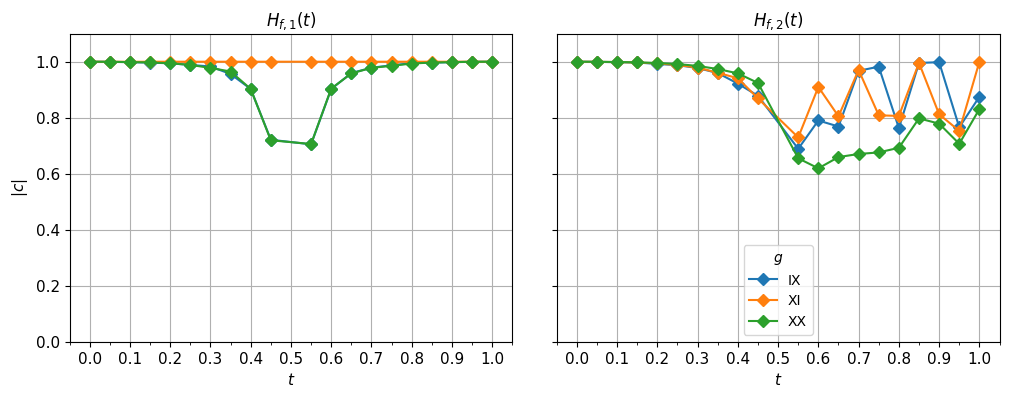

In [104]:
fig, [ax1, ax2] = plt.subplots(figsize=(12,4), ncols=2)

for k, ax in enumerate([ax1, ax2]):
    for j, (col, label) in enumerate(zip(colors, symmetry_labels[1:])):
        ax.plot(
            1-sub_interpolation_values, # I ordered this wrong at definition
            np.sqrt(1-correct_scores_array[k, :, j]),
            color=col,
            label=label,
            marker='D'
        )

    ax.set_ylim(0, 1.1)
    ax.xaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(0.1)
    )
    ax.xaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.05)
    )
    
    #ax.set_yscale('log')

    ax.tick_params(
        axis='both',
        which='major',
        labelsize=11
    )
    
    ax.grid()
    ax.grid(
        which='minor',
        axis='y',
        linestyle='--',
        zorder=-1e10
    )
    ax.set_axisbelow(True)

    if k == 0:
        ax.set_ylabel(r'$\vert c \vert$', fontsize=11)
    ax.set_xlabel('$t$', fontsize=11)

    if k == 1:
        ax.legend(loc='lower center', title='$g$')

    ax.title.set_text(rf'$H_{{f,{k+1}}}(t)$')
    ax.title.set_fontsize(12)

ax2.set_ylabel('')
ax2.set_yticklabels([])

fig.subplots_adjust(wspace=0.1)
    
#fig.savefig(r'plots/cost_function_from_mpo_fermionic.png', dpi=200)

Plot variances over all scores.

In [105]:
mean_overlaps_array = np.zeros((2, len(sub_interpolation_values), 3))
min_overlaps_array = np.zeros((2, len(sub_interpolation_values), 3))
max_overlaps_array = np.zeros((2, len(sub_interpolation_values), 3))

for i in range(2):
    for j, t in enumerate(sub_interpolation_values):
        for b in range(1, 4):
            sub_scores = {
                k: v for k, v in boundary_operator_scores.items()
                if (k[:3] == (i, t, b)) and (k[-1] < 5)
            }
            sub_scores_array = np.array(list(sub_scores.values()))
            overlaps_array = np.sqrt(1-sub_scores_array)

            mean_overlaps_array[i, j, b-1] = np.mean(overlaps_array)
            min_overlaps_array[i, j, b-1] = np.min(overlaps_array)
            max_overlaps_array[i, j, b-1] = np.max(overlaps_array)

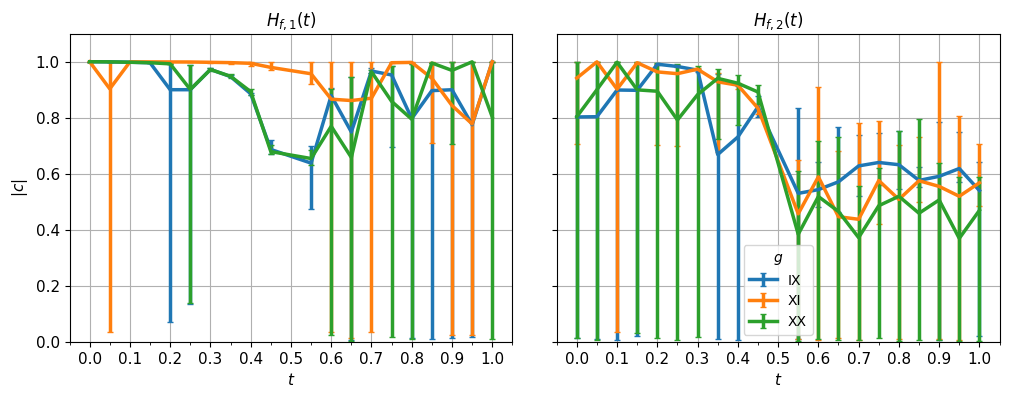

In [106]:
figure_label_fontsize=25
y_tick_label_fontsize=20
y_label_fontsize=25
x_tick_label_fontsize=20
x_label_fontsize=25
row_label_fontsize=25

axis_spine_linewidth = 1.5

major_tick_length = 8
major_tick_width = 1.8
minor_tick_length = 6
minor_tick_width = 1.2

phase_linewidth = 2.5

fig, [ax1, ax2] = plt.subplots(figsize=(12,4), ncols=2)

for k, ax in enumerate([ax1, ax2]):
    for j, (col, label) in enumerate(zip(colors, symmetry_labels[1:])):
        x_shift = 0.01*(i-1)
        ax.errorbar(
            1-sub_interpolation_values + x_shift, # I ordered this wrong at definition
            mean_overlaps_array[k, :, j],
            yerr=[
                (mean_overlaps_array-min_overlaps_array)[k, :, j],
                (max_overlaps_array-mean_overlaps_array)[k, :, j],
            ],
            color=col,
            label=label,
            fmt='-',
            capsize=2,
            linewidth=phase_linewidth,
        )

    ax.set_ylim(0, 1.1)
    ax.xaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(0.1)
    )
    ax.xaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.05)
    )
    
    #ax.set_yscale('log')

    ax.tick_params(
        axis='both',
        which='major',
        labelsize=11
    )
    
    ax.grid()
    ax.grid(
        which='minor',
        axis='y',
        linestyle='--',
        zorder=-1e10
    )
    ax.set_axisbelow(True)

    if k == 0:
        ax.set_ylabel(r'$\vert c \vert$', fontsize=11)
    ax.set_xlabel('$t$', fontsize=11)

    if k == 1:
        ax.legend(loc='lower center', title='$g$')

    ax.title.set_text(rf'$H_{{f,{k+1}}}(t)$')
    ax.title.set_fontsize(12)

ax2.set_ylabel('')
ax2.set_yticklabels([])

fig.subplots_adjust(wspace=0.1)
    
#fig.savefig(r'plots/cost_function_from_mpo_fermionic.png', dpi=200)

## Proj rep group cohomology

### Group data definitions

In [107]:
symmetry_labels = [
    'II',
    'IX',
    'XI',
    'XX'
]

In [108]:
symmetry_combination_labels = list(combinations(symmetry_labels, 2))

In [109]:
symmetry_combination_labels

[('II', 'IX'),
 ('II', 'XI'),
 ('II', 'XX'),
 ('IX', 'XI'),
 ('IX', 'XX'),
 ('XI', 'XX')]

In [110]:
e, a, b, c = symmetry_labels

In [111]:
group_products = [
    (a, b, c),
    (b, a, c),
    (a, c, b),
    (c, a, b),
    (c, b, a),
    (b, c, a)
]

### Evaluate

In [112]:
def rdm_trace(rdm):
    outer_inds = rdm.inds

    k_inds = sorted([
        i for i in outer_inds if i[0] == 'k'
    ])


    b_inds = sorted([
        i for i in outer_inds if i[0] == 'b'
    ])

    return rdm.trace(k_inds, b_inds)

In [113]:
def get_proj_rep_phase(rho, u_g, u_h, u_gh):
    us = [u_g.copy(), u_h.copy(), u_gh.copy()]

    relabel_circuit(us[0], 'k', 'l')
    relabel_circuit(us[1], 'l', 'm')
    relabel_circuit(us[2], 'b', 'm')

    us[2] = us[2].conj()

    out = (rho & us[0] & us[1] & us[2]) ^ ...
    out = rdm_trace(out)

    return (out/(np.abs(out)), np.abs(out))

In [114]:
def get_quimb_mps_from_tenpy_mps(tenpy_mps):
    psi_arrays = list()
    psi_arrays.append(tenpy_mps.get_B(0, 'Th')[0, ...].to_ndarray())
    for i in range(1, tenpy_mps.L-1):
        psi_arrays.append(tenpy_mps.get_B(i).to_ndarray())
    psi_arrays.append(tenpy_mps.get_B(tenpy_mps.L-1)[..., 0].to_ndarray())
    
    quimb_mps = (
        qtn
        .tensor_1d
        .MatrixProductState(psi_arrays, shape='lpr')
    )

    return quimb_mps

In [115]:
def get_proj_rep_phases(rho, unitaries):
    """
    quimb_mps = get_quimb_mps_from_tenpy_mps(tenpy_mps)
    sites = [
        int(s[1:]) for s in unitaries[0].ind_map
        if s[0]=='k'
    ]
    rho = quimb_mps.partial_trace_to_mpo(sites, rescale_sites=False)
    """
    out = list()

    unitaries_dict = {
        k: v for k, v in zip(symmetry_labels[1:], unitaries)
    }

    out_phases = list()
    for a, b, c in group_products:
        phase = get_proj_rep_phase(
            rho,
            unitaries_dict[a],
            unitaries_dict[b],
            unitaries_dict[c]
        )

        out_phases.append(phase)

    return out_phases

In [116]:
bs = bosonic_np_symmetries[0]
fs = fermionic_np_symmetries[0]

symmetry_site_pairs = (
    [(i, bs) for i in range(left_most_symmetry_site, left_most_symmetry_site+num_symmetry_sites, 2)]
    + [(i, fs) for i in range(left_most_symmetry_site+1, left_most_symmetry_site+num_symmetry_sites+1, 2)]
)

Step through:

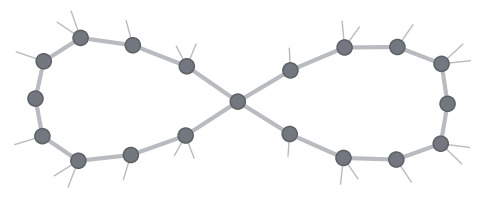

In [117]:
rdm.draw()

In [118]:
triv_proj_rep_phases = list()

for t in sub_interpolation_values:
    tenpy_mps = loaded_data_triv_proj_rep[t]
    
    rdm = generate_rdm_from_tenpy_psi(
        tenpy_psi,
        symmetry_site_pairs,
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites
    )

    unitaries = [
        correct_boundary_operators[(0, t, i)]
        for i in [1,2,3]
    ]

    left_unitaries, right_unitaries = zip(*unitaries)

    left_phases = get_proj_rep_phases(rdm, left_unitaries)
    right_phases = get_proj_rep_phases(rdm, right_unitaries)

    triv_proj_rep_phases.append([left_phases, right_phases])

In [119]:
triv_proj_rep_phases = np.array(triv_proj_rep_phases)

In [120]:
triv_proj_rep_phases.shape

(20, 2, 6, 2)

In [121]:
np.round(
    triv_proj_rep_phases[..., ::2, 0]/triv_proj_rep_phases[..., 1::2, 0],
    2
)

array([[[1.  -0.j  , 1.  +0.j  , 1.  -0.j  ],
        [1.  +0.j  , 1.  -0.j  , 1.  -0.j  ]],

       [[0.99-0.12j, 1.  -0.02j, 1.  +0.j  ],
        [1.  +0.j  , 1.  -0.j  , 1.  +0.j  ]],

       [[1.  -0.02j, 0.89+0.46j, 1.  -0.08j],
        [1.  +0.j  , 1.  -0.05j, 1.  +0.j  ]],

       [[1.  -0.j  , 1.  -0.07j, 1.  +0.j  ],
        [1.  -0.07j, 1.  -0.02j, 1.  +0.02j]],

       [[1.  -0.j  , 1.  +0.j  , 1.  +0.j  ],
        [1.  -0.08j, 1.  -0.03j, 0.99+0.14j]],

       [[1.  +0.j  , 0.88+0.48j, 1.  +0.j  ],
        [1.  -0.j  , 1.  +0.01j, 1.  +0.j  ]],

       [[1.  -0.j  , 1.  -0.j  , 1.  -0.j  ],
        [1.  -0.j  , 1.  +0.j  , 1.  +0.j  ]],

       [[1.  -0.j  , 1.  +0.j  , 1.  -0.j  ],
        [1.  +0.j  , 1.  +0.01j, 1.  +0.j  ]],

       [[1.  -0.j  , 1.  -0.01j, 1.  -0.j  ],
        [1.  +0.j  , 1.  +0.j  , 1.  +0.j  ]],

       [[1.  +0.j  , 1.  +0.j  , 1.  +0.j  ],
        [1.  +0.j  , 1.  -0.j  , 1.  +0.j  ]],

       [[1.  +0.j  , 1.  -0.j  , 1.  +0.j  ],
        [1.  -

In [122]:
triv_gauge_invariant_proj_rep_phase = triv_proj_rep_phases[..., ::2, 0]/triv_proj_rep_phases[..., 1::2, 0]

In [123]:
non_triv_proj_rep_phases = list()

for t in sub_interpolation_values:
    tenpy_mps = loaded_data_non_triv_proj_rep[t]

    rdm = generate_rdm_from_tenpy_psi(
        tenpy_psi,
        symmetry_site_pairs,
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites
    )

    unitaries = [
        correct_boundary_operators[(1, t, i)]
        for i in [1,2,3]
    ]

    left_unitaries, right_unitaries = zip(*unitaries)

    left_phases = get_proj_rep_phases(rdm, left_unitaries)
    right_phases = get_proj_rep_phases(rdm, right_unitaries)

    non_triv_proj_rep_phases.append([left_phases, right_phases])

In [124]:
non_triv_proj_rep_phases = np.array(non_triv_proj_rep_phases)

In [125]:
non_triv_proj_rep_phases.shape

(20, 2, 6, 2)

In [126]:
np.round(
    non_triv_proj_rep_phases[..., ::2, 0]/non_triv_proj_rep_phases[..., 1::2, 0],
    2
)

array([[[-1.  +0.j  , -0.99-0.12j, -1.  +0.08j],
        [-0.95+0.32j, -0.99+0.14j, -1.  +0.j  ]],

       [[-0.77+0.64j, -0.77+0.64j, -1.  +0.j  ],
        [-1.  -0.01j,  0.98+0.18j, -1.  -0.07j]],

       [[-0.99+0.11j, -1.  -0.04j, -1.  +0.01j],
        [-0.83+0.56j, -0.81-0.58j, -1.  -0.02j]],

       [[-1.  -0.08j, -0.99+0.15j, -1.  -0.04j],
        [-0.01+1.j  , -0.02+1.j  , -0.02-1.j  ]],

       [[-0.98-0.2j , -0.97-0.26j, -1.  +0.02j],
        [-1.  +0.09j, -1.  -0.04j, -0.97+0.24j]],

       [[-1.  -0.07j, -0.97+0.25j, -0.48+0.88j],
        [-0.99+0.13j, -0.99-0.15j, -0.96+0.27j]],

       [[-1.  +0.03j, -1.  -0.01j, -0.99+0.1j ],
        [-1.  -0.j  , -1.  +0.03j, -1.  +0.j  ]],

       [[-1.  +0.02j, -1.  +0.09j, -1.  +0.06j],
        [-0.99-0.12j, -0.91+0.41j, -0.93-0.37j]],

       [[-0.91+0.42j, -0.91+0.41j, -0.94-0.35j],
        [-1.  -0.01j, -1.  -0.06j, -0.97+0.26j]],

       [[-0.99-0.1j , -1.  -0.03j, -0.79+0.61j],
        [-0.62+0.78j, -0.67+0.74j, -0.99+0.13j]],



In [127]:
non_triv_gauge_invariant_proj_rep_phase = non_triv_proj_rep_phases[..., ::2, 0]/non_triv_proj_rep_phases[..., 1::2, 0]

In [128]:
gauge_invariant_proj_rep_phase = np.stack(
    [
        triv_gauge_invariant_proj_rep_phase,
        non_triv_gauge_invariant_proj_rep_phase
    ],
    axis=0
)

In [129]:
gauge_invariant_proj_rep_real_phase = np.real(gauge_invariant_proj_rep_phase)
mean_gauge_invariant_proj_rep_real_phase = np.mean(gauge_invariant_proj_rep_real_phase, axis=(2,3))
max_gauge_invariant_proj_rep_real_phase = np.max(gauge_invariant_proj_rep_real_phase, axis=(2,3))
min_gauge_invariant_proj_rep_real_phase = np.min(gauge_invariant_proj_rep_real_phase, axis=(2,3))

min_max_gauge_invariant_proj_rep_real_phase = np.stack(
    [
        min_gauge_invariant_proj_rep_real_phase,
        max_gauge_invariant_proj_rep_real_phase
    ],
    axis=0
)

error_gauge_invariant_proj_rep_real_phase = (
    min_max_gauge_invariant_proj_rep_real_phase
    - mean_gauge_invariant_proj_rep_real_phase[np.newaxis, ...]
)
error_gauge_invariant_proj_rep_real_phase = np.abs(error_gauge_invariant_proj_rep_real_phase)

In [130]:
gauge_invariant_proj_rep_angle = np.imag(np.log(gauge_invariant_proj_rep_phase))
gauge_invariant_proj_rep_angle[gauge_invariant_proj_rep_angle<=-np.pi/2] += 2*np.pi

In [131]:
mean_gauge_invariant_proj_rep_angle = np.mean(gauge_invariant_proj_rep_angle, axis=(2,3))
max_gauge_invariant_proj_rep_angle = np.max(gauge_invariant_proj_rep_angle, axis=(2,3))
min_gauge_invariant_proj_rep_angle = np.min(gauge_invariant_proj_rep_angle, axis=(2,3))

min_max_gauge_invariant_proj_rep_angle = np.stack(
    [
        min_gauge_invariant_proj_rep_angle,
        max_gauge_invariant_proj_rep_angle
    ],
    axis=0
)

error_gauge_invariant_proj_rep_angle = (
    min_max_gauge_invariant_proj_rep_angle
    - mean_gauge_invariant_proj_rep_angle[np.newaxis, :]
)
error_gauge_invariant_proj_rep_angle = np.abs(error_gauge_invariant_proj_rep_angle)

In [132]:
markers = ['<', '>']

In [133]:
colors = [
    'tab:blue',
    'tab:orange',
    'tab:green'
]   

In [134]:
e, a, b, c = symmetry_labels

In [135]:
symmetry_pair_labels = [
    a + ',' + b,
    a + ',' + c,
    c + ',' + b
]

In [136]:
side_labels = ['Left', 'Right']

In [137]:
mean_gauge_invariant_proj_rep_real_phase.shape

(2, 20)

In [138]:
error_gauge_invariant_proj_rep_real_phase.shape

(2, 2, 20)

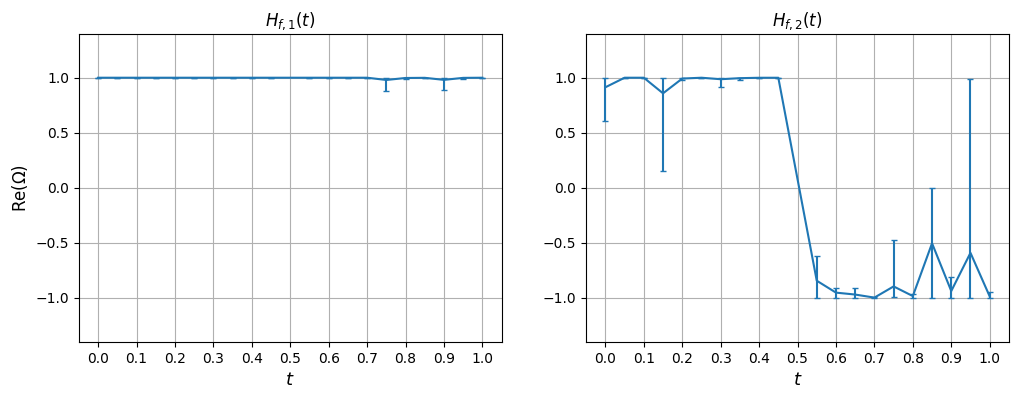

In [139]:
fig, [ax1, ax2] = plt.subplots(figsize=(12,4), ncols=2)

for k, ax in enumerate([ax1, ax2]):
    ax.errorbar(
        1-sub_interpolation_values,
        mean_gauge_invariant_proj_rep_real_phase[k],
        yerr=error_gauge_invariant_proj_rep_real_phase[:, k],
    color='tab:blue',
    fmt='-',
    capsize=2
    )
    
    ax.xaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(0.1)
    )
    
    ax.grid()
    if k == 0:
        ax.set_ylabel(r'Re$(\Omega)$', fontsize=12)
    ax.set_xlabel('$t$', fontsize=13)

    """
    if k == 1:
        ax.legend(loc='upper right', title='$(g,h)$, Side')
    """

    ax.title.set_text(rf'$H_{{f,{k+1}}}(t)$')
    ax.set_ylim(-1.4, 1.4)

#fig.suptitle(r'$\Delta \Theta(g,h)$ as a function of $B$')

#fig.savefig(r'plots/proj_rep_omega_fermionic_variational_unitary_2_site.png', dpi=200)

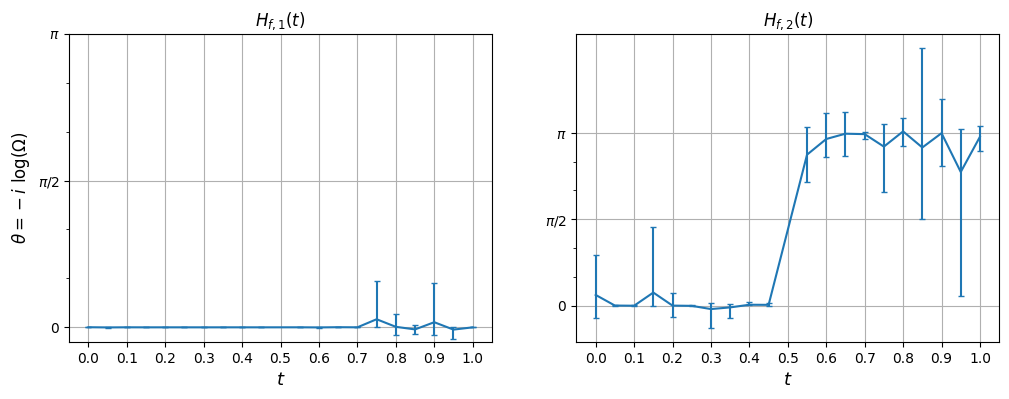

In [140]:
fig, [ax1, ax2] = plt.subplots(figsize=(12,4), ncols=2)

for k, ax in enumerate([ax1, ax2]):
    ax.errorbar(
        1-sub_interpolation_values,
        mean_gauge_invariant_proj_rep_angle[k],
        yerr=error_gauge_invariant_proj_rep_angle[:, k],
    color='tab:blue',
    fmt='-',
    capsize=2
    )
    
    ax.xaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(0.1)
    )
    
    ax.grid()
    if k == 0:
        ax.set_ylabel(r'$\theta=-i\ \log(\Omega)$', fontsize=12)
    ax.set_xlabel('$t$', fontsize=13)

    """
    if k == 1:
        ax.legend(loc='upper right', title='$(g,h)$, Side')
    """

    ax.title.set_text(rf'$H_{{f,{k+1}}}(t)$')
    #ax.set_ylim(-1.4, 1.4)

    ax.set_yticks(
        np.linspace(0, np.pi, 3),
        labels=['$0$', '$\pi/2$', '$\pi$']
    )
    
    ax.set_yticks(
        [np.pi/6, np.pi/3, 2*np.pi/3, 5*np.pi/6],
        minor=True
    )
#fig.suptitle(r'$\Delta \Theta(g,h)$ as a function of $B$')

#fig.savefig(r'plots/proj_rep_omega_fermionic_variational_unitary_2_site.png', dpi=200)

# Conclusion
Again, looks like solutions are not fully converged.